## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

## Load

In [2]:
tmp = sc.read('data/segmentoid.h5ad')

In [3]:
segmentoid = tmp[~tmp.obs['timepoint'].isin(['iPSC']),:]

In [4]:
somitoid = sc.read('data/somitoid.h5ad')

In [5]:
adata = segmentoid.concatenate(somitoid)

## Pre process

In [6]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=65000)
sc.pp.filter_cells(adata, min_genes=3000)
sc.pp.filter_cells(adata, max_genes=8000)

In [7]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [8]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
adata = adata[adata.obs['pct_counts_mito'] < 10, :]

In [9]:
adata.raw = adata

In [10]:
sc.pp.normalize_total(adata)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500)

In [13]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'sample' as categorical
... storing 'type' as categorical
... storing 'timepoint' as categorical
... storing 'phase' as categorical


In [14]:
sc.pp.scale(adata)

In [15]:
sc.tl.pca(adata, n_comps=50)

In [16]:
sce.pp.bbknn(adata, batch_key='timepoint', local_connectivity=10)

In [17]:
sc.tl.umap(adata)

In [18]:
sc.tl.leiden(adata, resolution=.9)

In [19]:
adata.obs['leiden'] = adata.obs['leiden'].replace(['0'],'PSM Post')
adata.obs['leiden'] = adata.obs['leiden'].replace(['1'],'Somite')
adata.obs['leiden'] = adata.obs['leiden'].replace(['2'],'Somite')
adata.obs['leiden'] = adata.obs['leiden'].replace(['3'],'NMP')
adata.obs['leiden'] = adata.obs['leiden'].replace(['4'],'PSM Ant')
adata.obs['leiden'] = adata.obs['leiden'].replace(['5'],'iPSC')
adata.obs['leiden'] = adata.obs['leiden'].replace(['6'],'PSM Ant')
adata.obs['leiden'] = adata.obs['leiden'].replace(['7'],'NMP/Neural')

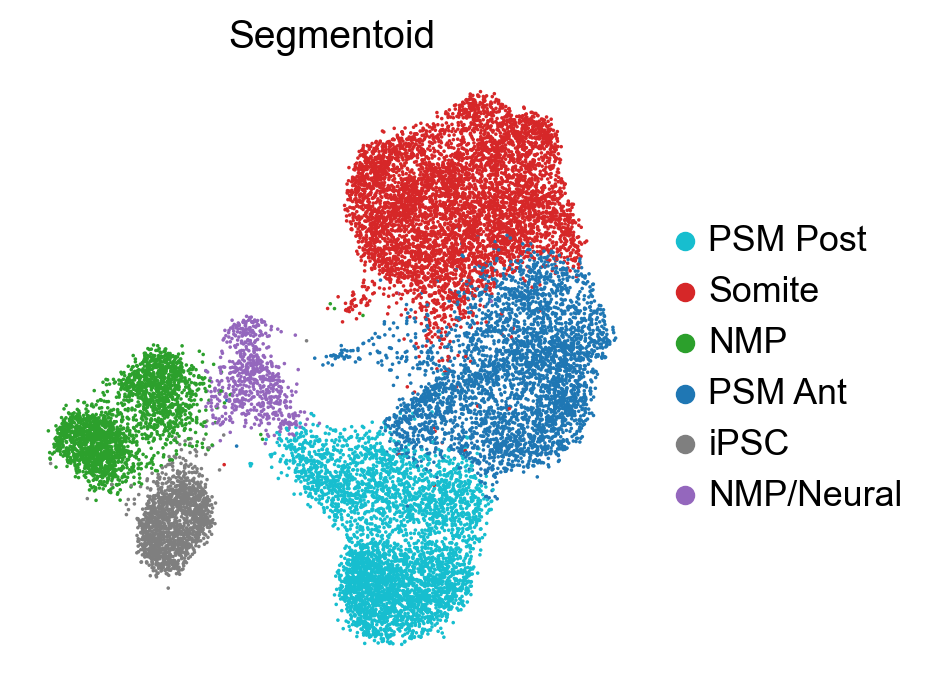

In [20]:
sc.pl.umap(adata, color=['leiden'], title='Segmentoid', palette=['tab:cyan', 'tab:red', 'tab:green', 'tab:blue', 'tab:gray', 'tab:purple'])

## NMP/NEURAL SPLIT - LEIDEN CORRECTION

In [21]:
tmp = adata[adata.obs['leiden'].isin(['NMP/Neural']),:]
adata_sc = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var,uns=tmp.uns,obsm=tmp.obsm,obsp=tmp.obsp)

In [22]:
adata_sc.raw = adata_sc

In [23]:
sc.tl.umap(adata_sc)

In [24]:
sc.tl.leiden(adata_sc, resolution=.2, key_added='leiden_sc')

In [25]:
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['0'],'NMP')
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['1'],'Neural')

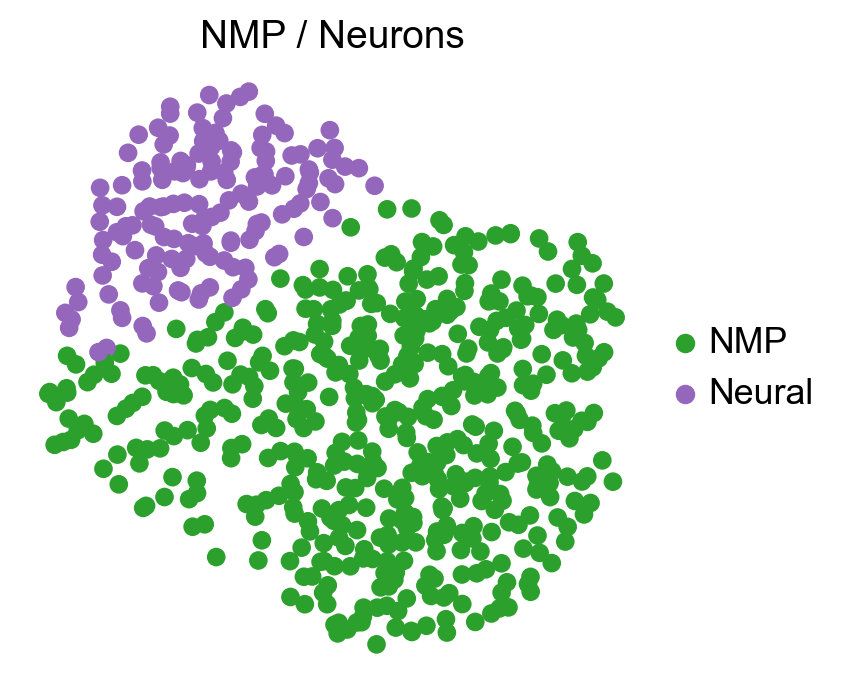

In [26]:
sc.pl.umap(adata_sc, color=['leiden_sc'], title='NMP / Neurons', palette=['tab:green', 'tab:purple'])

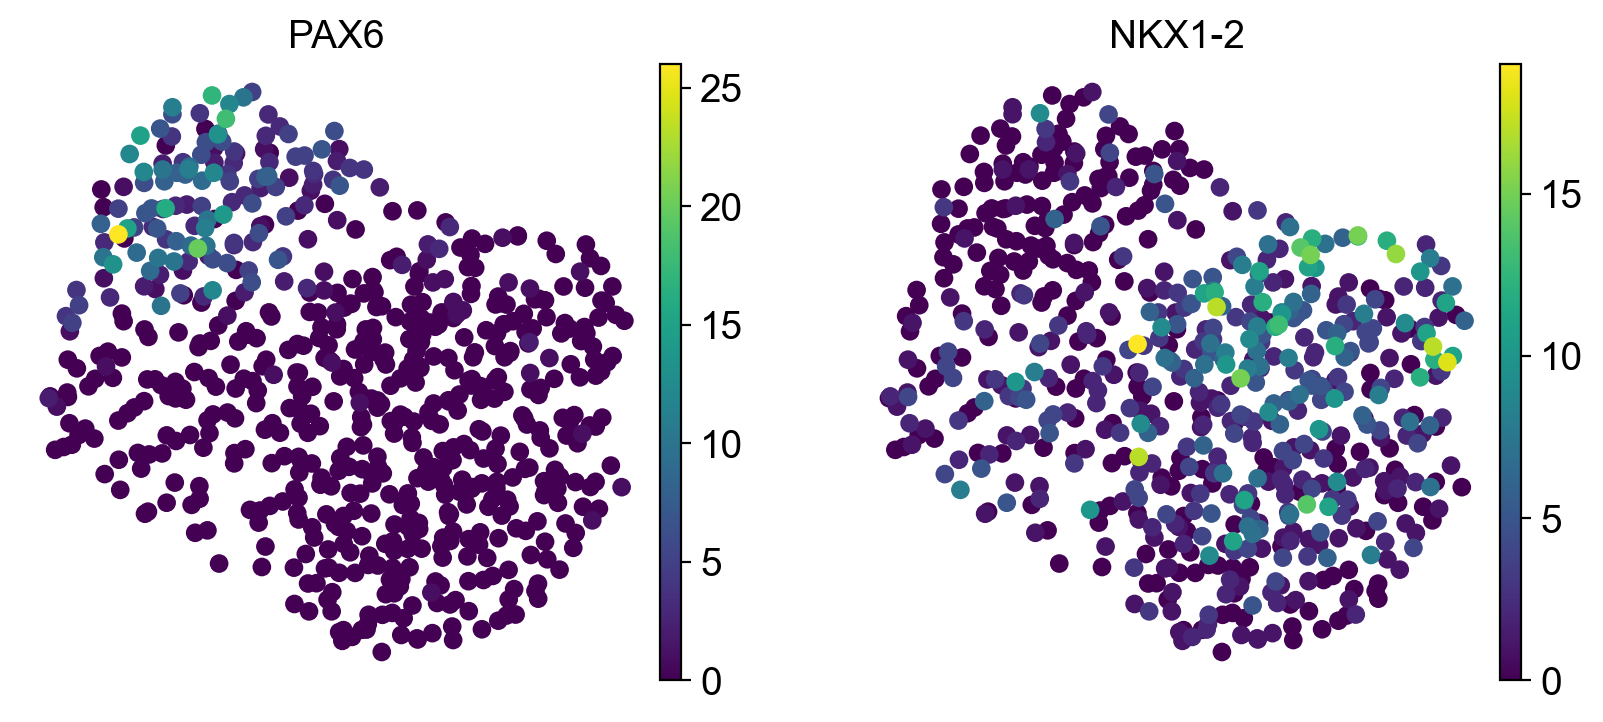

In [27]:
sc.pl.umap(adata_sc, color=['PAX6', 'NKX1-2'], color_map='viridis')

## Reinjection

In [28]:
obs = adata_sc.obs_names.to_list()

In [29]:
tmp=adata[~adata.obs_names.isin(obs),:]
adata_bis = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var)

In [30]:
tmp_2=adata_sc
adata_sc2 = sc.AnnData(tmp_2.raw.X,obs=tmp_2.obs,var=tmp_2.raw.var)
adata_sc2.obs['leiden']=adata_sc2.obs['leiden_sc']

In [31]:
adata_injected = adata_sc2.concatenate(adata_bis, batch_key='batch_layer_2')

## Identical preprocess

In [32]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [33]:
adata_injected.raw = adata_injected

In [34]:
sc.pp.normalize_total(adata_injected)

In [35]:
sc.pp.log1p(adata_injected)

In [36]:
sc.pp.highly_variable_genes(adata_injected, n_top_genes=1500)

In [37]:
sc.pp.regress_out(adata_injected, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'leiden' as categorical


In [38]:
sc.pp.scale(adata_injected)

In [39]:
sc.tl.pca(adata_injected, n_comps=50)

In [40]:
sce.pp.bbknn(adata_injected, batch_key='timepoint', local_connectivity=10)

In [41]:
sc.tl.umap(adata_injected)

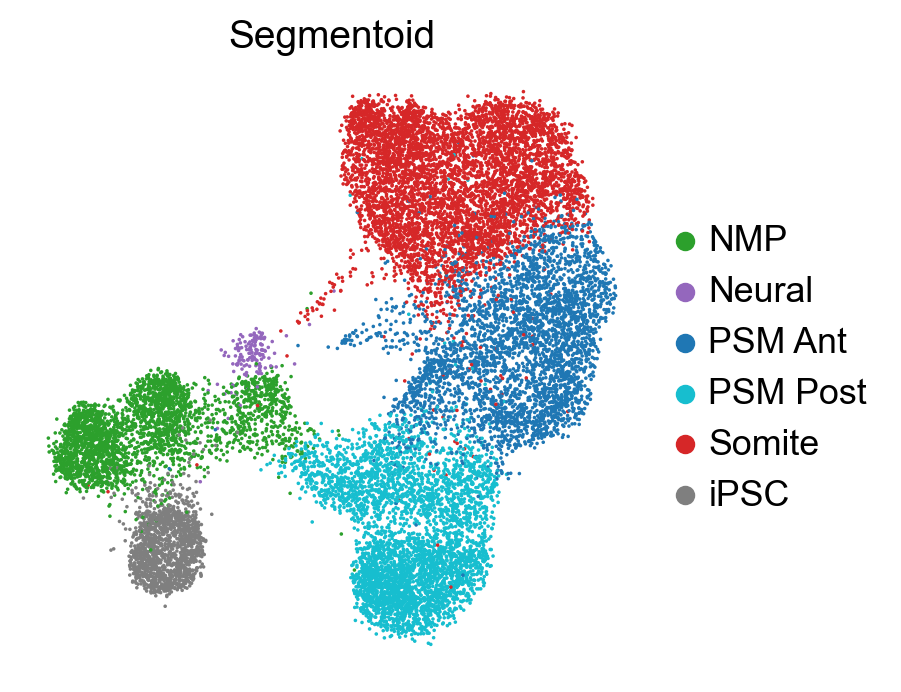

In [42]:
sc.pl.umap(adata_injected, color=['leiden'], title='Segmentoid', palette=['tab:green', 'tab:purple', 'tab:blue', 'tab:cyan', 'tab:red', 'tab:gray'])

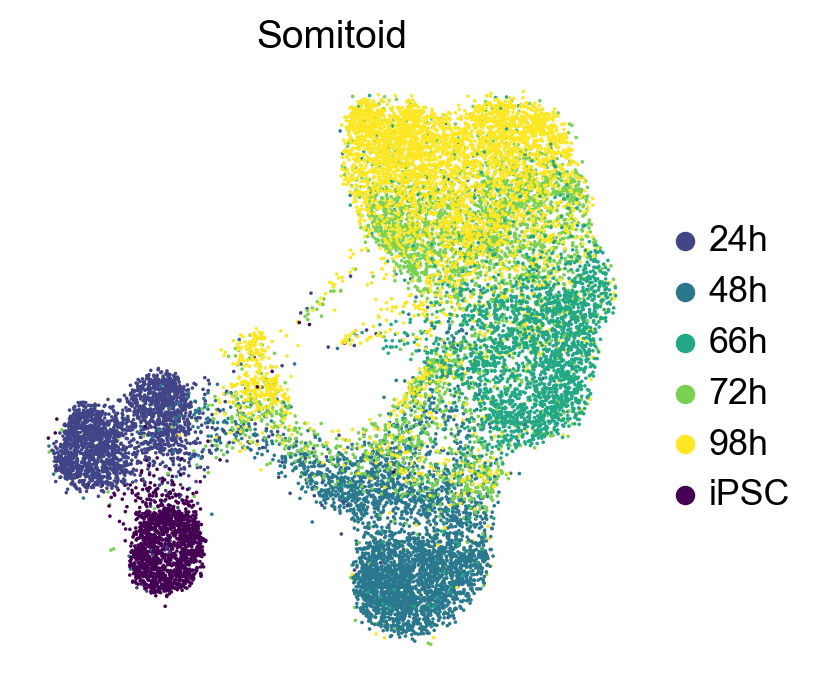

In [43]:
sc.pl.umap(adata_injected, color=['timepoint'], title='Somitoid', palette=['#414487', '#2a788e', '#22a884', '#7ad151', '#fde725','#440154'])

In [44]:
adata_injected.obs["type_timepoint"] = [adata_injected.obs.loc[x, "type"] + "-" + adata_injected.obs.loc[x, "timepoint"] for x in adata_injected.obs.index]

... storing 'type_timepoint' as categorical


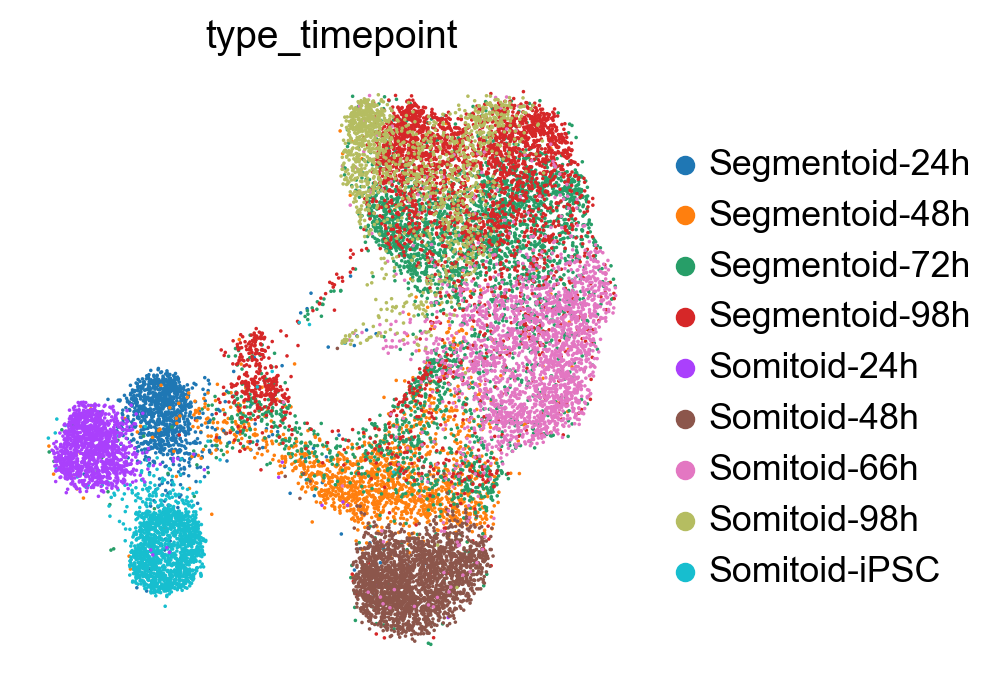

In [45]:
sc.pl.umap(adata_injected, color = "type_timepoint")

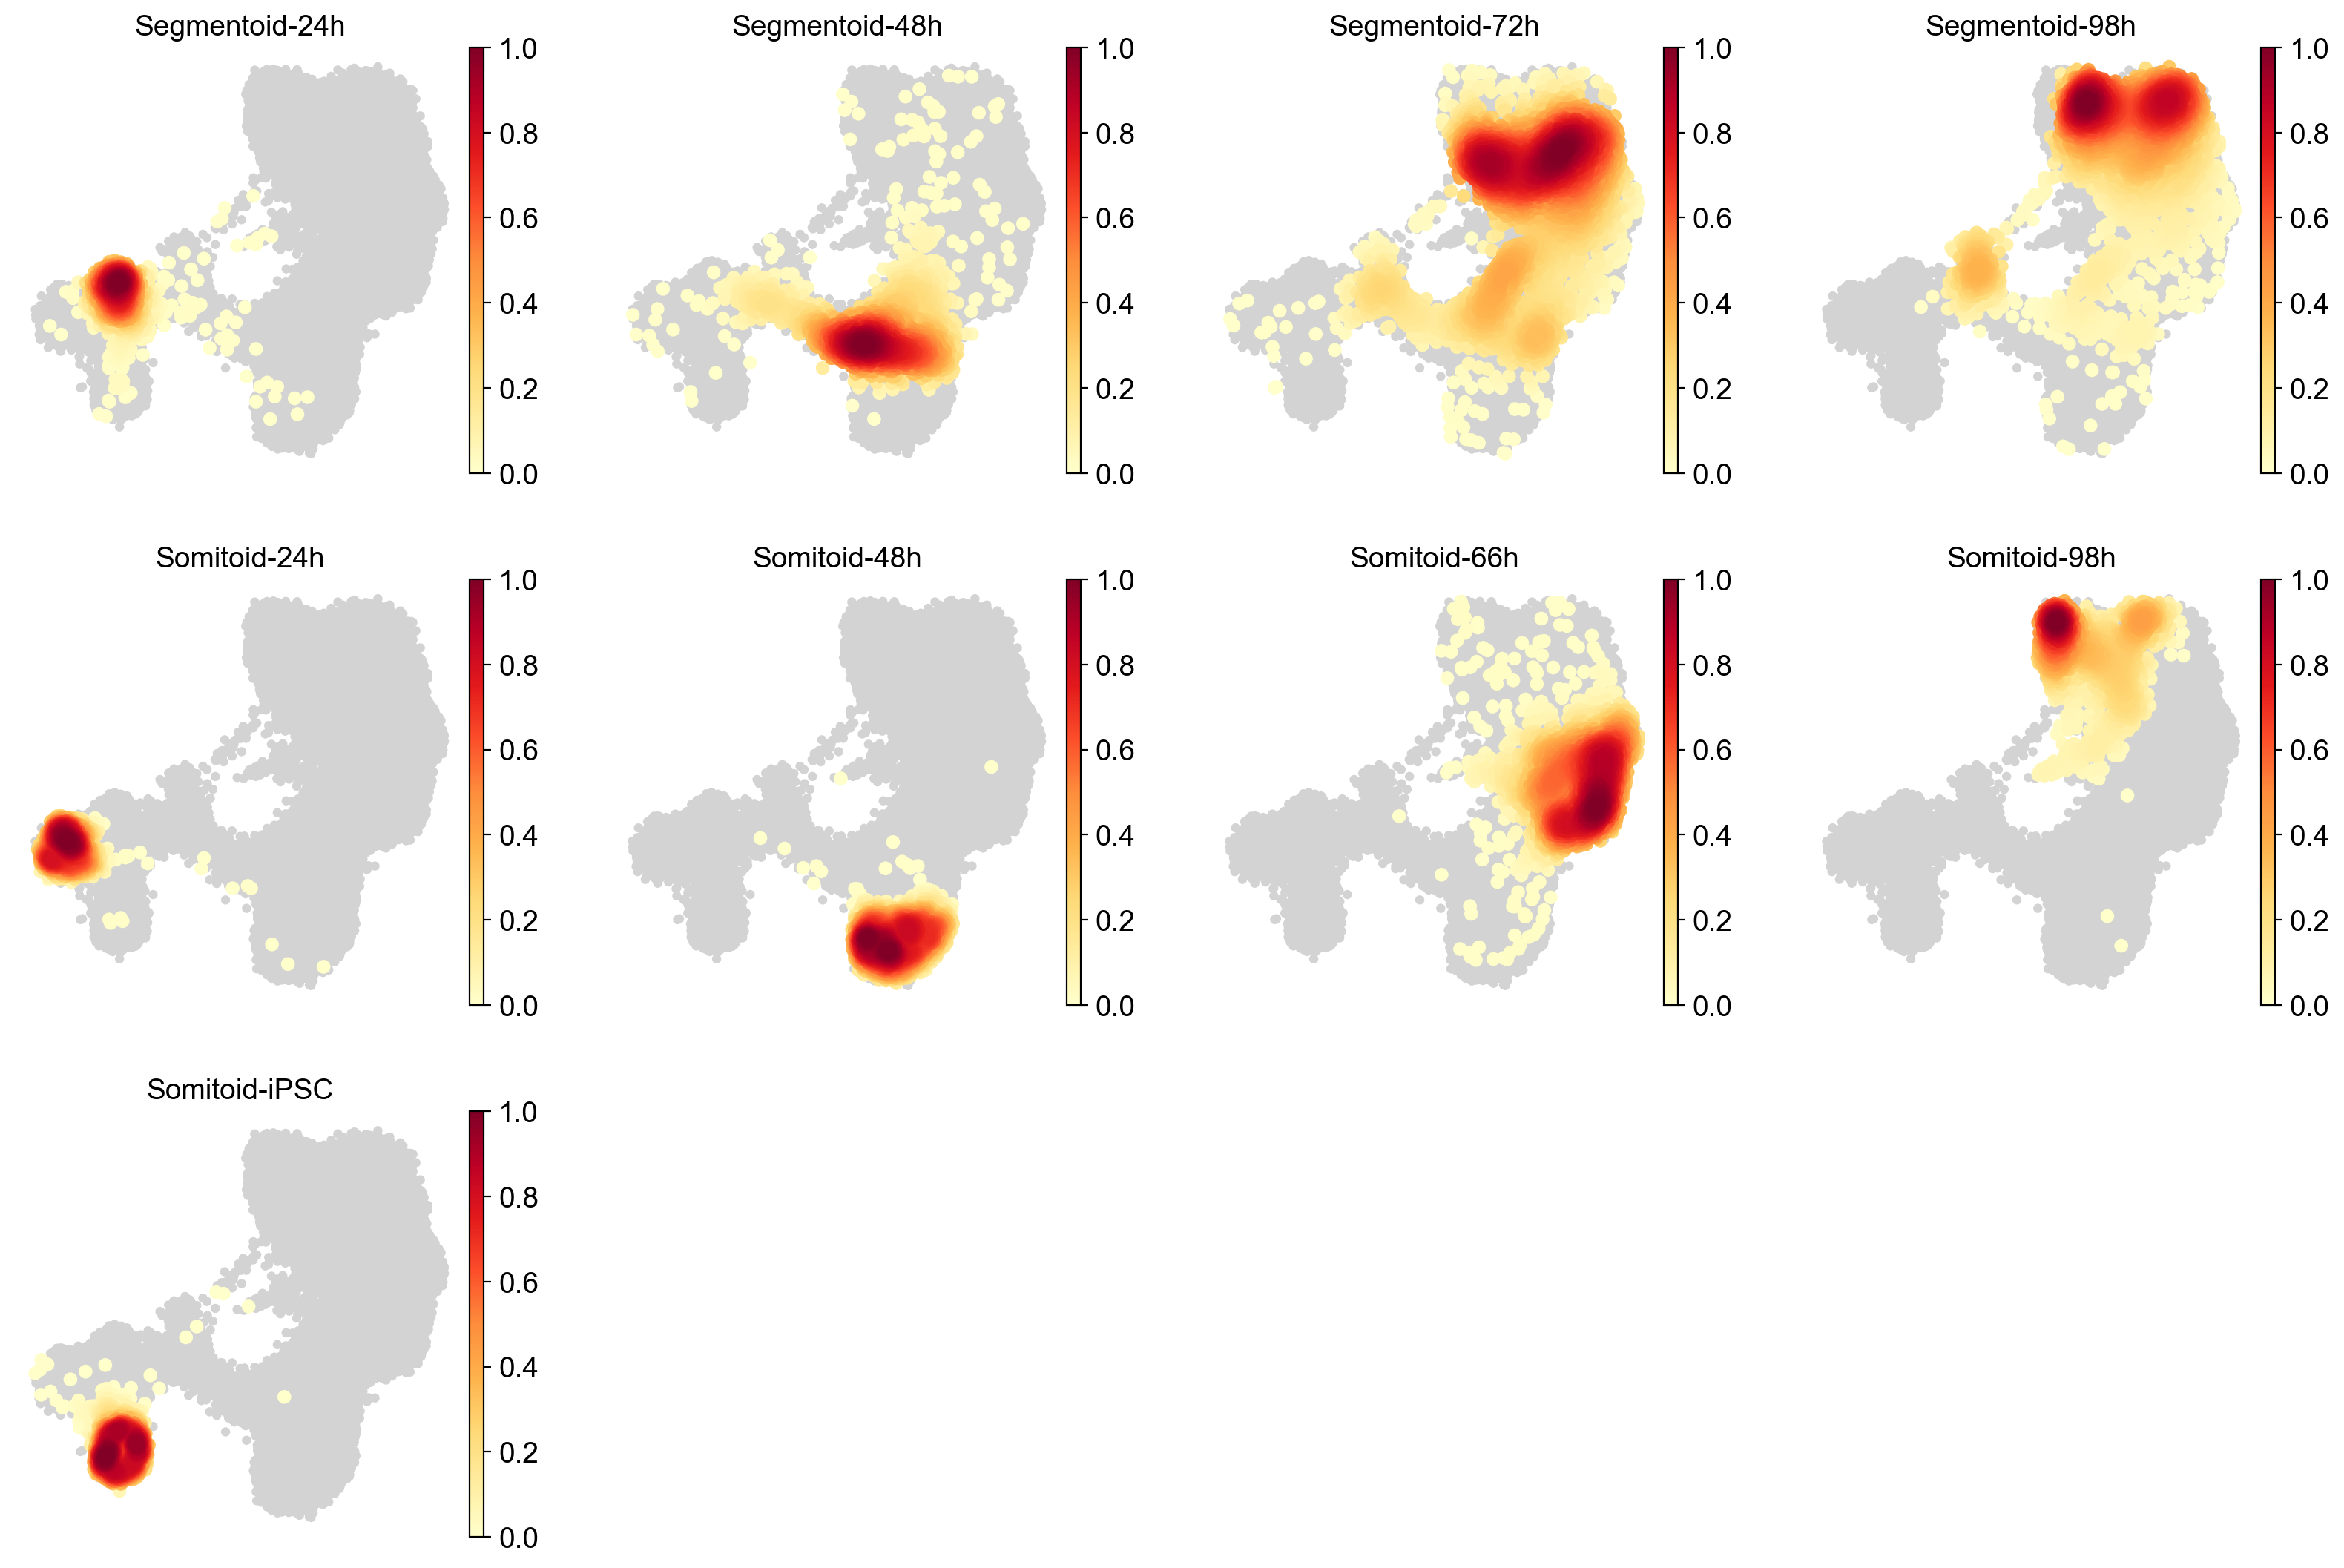

In [46]:
sc.tl.embedding_density(adata_injected, basis='umap', groupby='type_timepoint')
sc.pl.embedding_density(adata_injected, basis='umap', key='umap_density_type_timepoint', group =adata_injected.obs.type_timepoint.cat.categories.to_list())

## Gene expression

In [47]:
sc.tl.rank_genes_groups(adata_injected, groupby='leiden', use_raw=True, method='wilcoxon', corr_method='benjamini-hochberg')
pd.DataFrame(adata_injected.uns['rank_genes_groups']['names']).iloc[0:20,:]

,NMP,Neural,PSM Ant,PSM Post,Somite,iPSC
0,CNTNAP2,SOX2,MEST,MSGN1,IGFBP5,TERF1
1,TUBB2B,PAX6,SLC5A3,RSPO3,SEPTIN11,CD24
2,LINC01356,IGFBP2,MRPS6,TBX6,NR2F2,MIR302CHG
3,GAL,CDH6,FOXC2,HES7,NR2F1,FOXD3-AS1
4,TUBB2A,TTYH1,CXCR4,DLL3,BOC,USP44
5,EPCAM,CRABP2,SSTR2,HES6,ALCAM,UGP2
6,L1TD1,PPP1R1A,APLNR,CDX2,PAX3,LINC00678
7,SERPINE2,CA4,DLL3,FGF17,PTN,L1TD1
8,KRT18,HMGN2,ARHGAP10,ABLIM1,SIX1,RARRES2
9,GSTO1,PRSS23,HOXB-AS3,CITED1,SERPINF1,TDGF1


In [48]:
order_dotplot = ['iPSC', 'NMP', 'Neural', 'PSM Post', 'PSM Ant', 'Somite']

In [49]:
markers = ['SOX2', 'POU5F1', 'NKX1-2', 'TBXT', 'PAX6', 'HES7', 'MSGN1', 'TBX6', 'DLL1', 'RIPPLY2', 'MEOX1', 'MESP2', 'TCF15', 
          'MYOCD', 'UNCX', 'TBX18', 'PAX3']

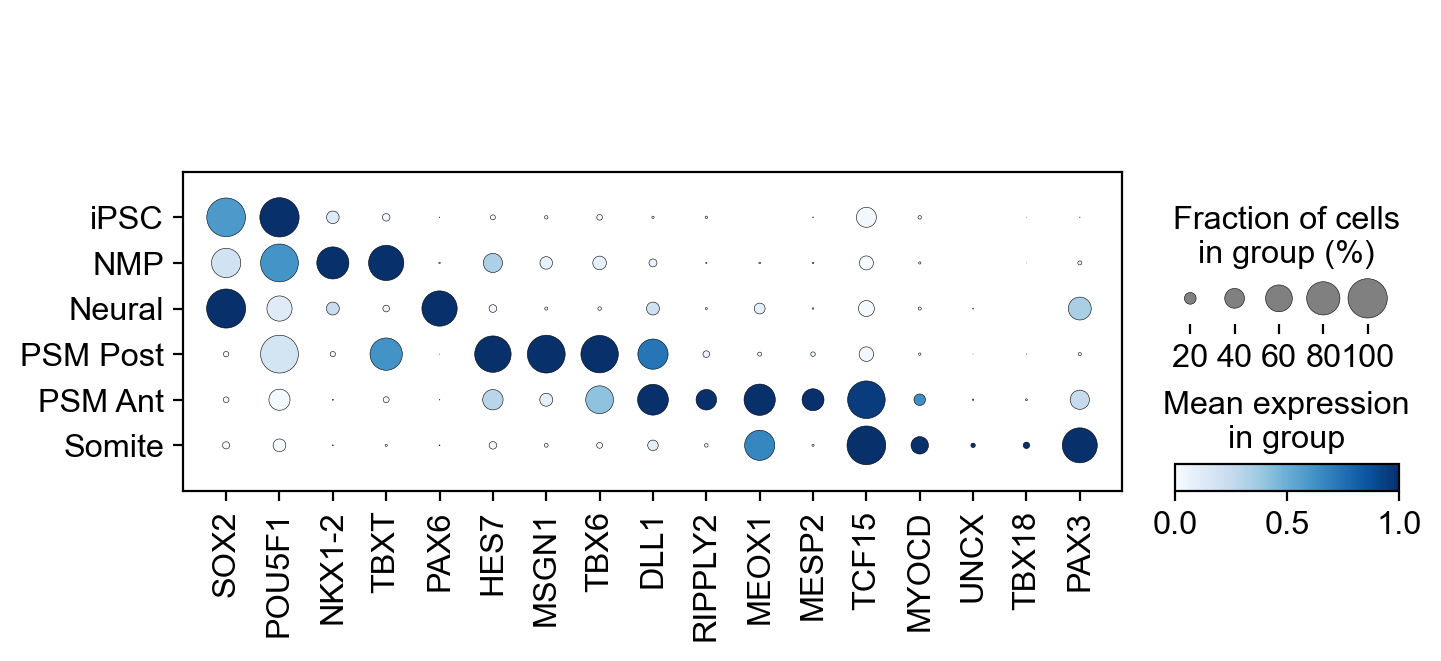

In [50]:
sc.pl.dotplot(adata_injected, markers, 'leiden', categories_order=order_dotplot, return_fig=False,color_map='Blues', standard_scale='var')

## TBX18 / UNCX

In [51]:
adata_df = pd.DataFrame(adata_injected.raw.X.toarray(), index = adata_injected.obs.index, columns = adata_injected.raw.var.index)
index_TBX18 = adata_df[adata_df.TBX18 > 0].index 
adata_TBX18 = adata_injected[adata_injected.obs.index.isin(index_TBX18)]
adata_TBX18.obs['gene_subset'] = 'TBX18'
print('TBX18+ cells : ' + str(adata_TBX18.shape[0]))

Trying to set attribute `.obs` of view, copying.


TBX18+ cells : 590


In [52]:
adata_df = pd.DataFrame(adata_injected.raw.X.toarray(), index = adata_injected.obs.index, columns = adata_injected.raw.var.index)
index_UNCX = adata_df[adata_df.UNCX > 0].index 
adata_UNCX = adata_injected[adata_injected.obs.index.isin(index_UNCX)]
adata_UNCX.obs['gene_subset'] = 'UNCX'
print('UNCX+ cells : ' + str(adata_UNCX.shape[0]))

Trying to set attribute `.obs` of view, copying.


UNCX+ cells : 362


In [53]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
print('TBX18+ and UNCX+ cells : ' + str(len(intersection(adata_TBX18.obs_names.to_list(), adata_UNCX.obs_names.to_list()))))

TBX18+ and UNCX+ cells : 9


In [54]:
adata_TBX18=sc.AnnData(adata_TBX18.raw.X,obs=adata_TBX18.obs,var=adata_TBX18.raw.var)
adata_UNCX=sc.AnnData(adata_UNCX.raw.X,obs=adata_UNCX.obs,var=adata_UNCX.raw.var)

In [55]:
adata_gene_subset = adata_TBX18.concatenate(adata_UNCX)

In [56]:
adata_gene_subset.raw = adata_gene_subset

In [57]:
sc.pp.normalize_total(adata_gene_subset)

In [58]:
sc.pp.log1p(adata_gene_subset)

In [59]:
sc.pp.highly_variable_genes(adata_gene_subset)

In [60]:
sc.pp.scale(adata_gene_subset)

In [61]:
sc.tl.pca(adata_gene_subset, n_comps=50)

In [62]:
sce.pp.bbknn(adata_gene_subset, batch_key='type', local_connectivity=10)

In [63]:
sc.tl.umap(adata_gene_subset, min_dist=0.4)

... storing 'sample' as categorical
... storing 'timepoint' as categorical
... storing 'leiden' as categorical
... storing 'leiden_sc' as categorical
... storing 'type_timepoint' as categorical
... storing 'gene_subset' as categorical


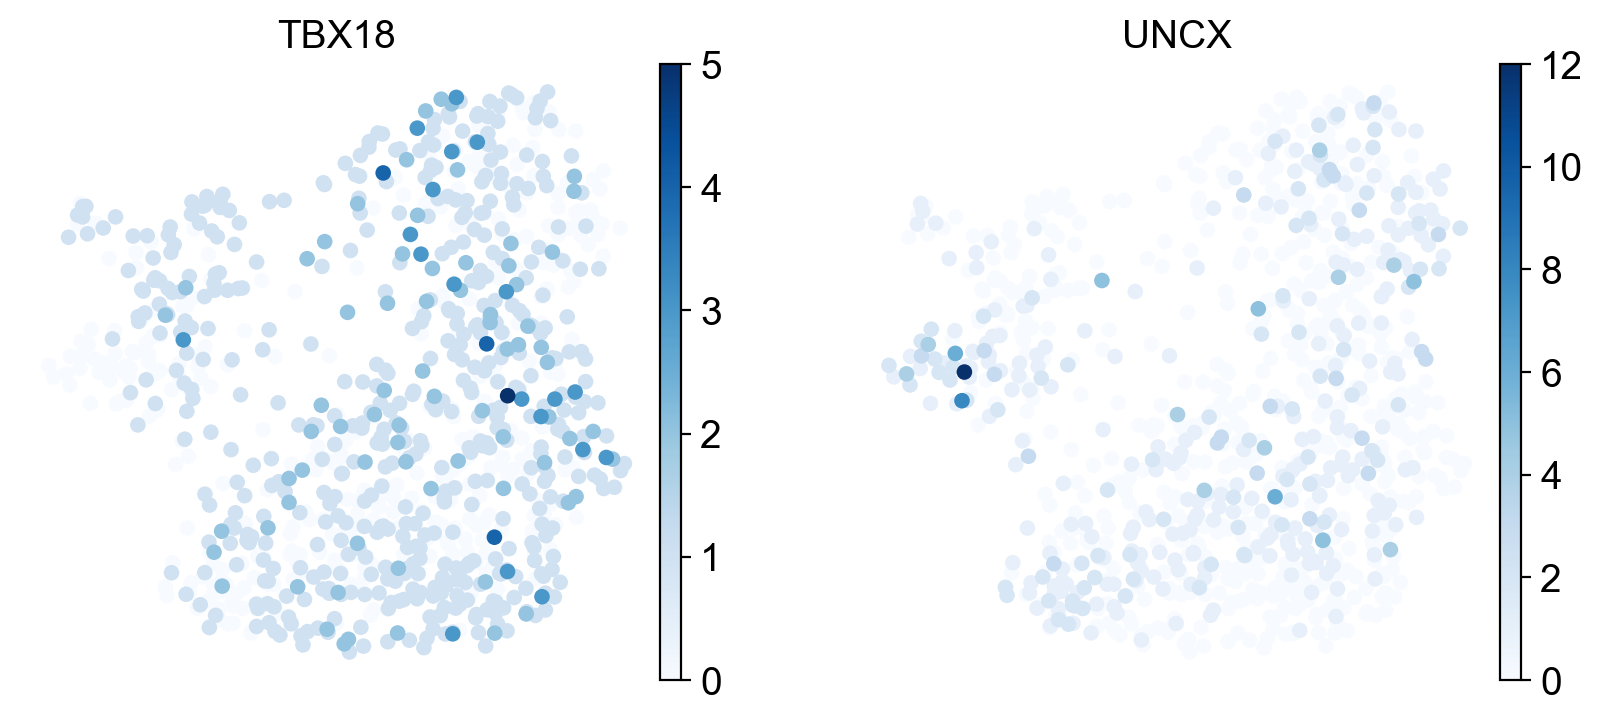

In [64]:
sc.pl.umap(adata_gene_subset, color=['TBX18', 'UNCX'], color_map='Blues')

In [66]:
sc.tl.rank_genes_groups(adata_gene_subset, groupby='gene_subset', method = "wilcoxon", n_jobs=-1)
excel_total = pd.DataFrame(adata_gene_subset.uns['rank_genes_groups']['names']).iloc[0:1000,:]
excel_total.to_excel("figures/TBX18_UNCX.xlsx")
excel_total.head(5)

,TBX18,UNCX
0,TBX18,UNCX
1,DSC2,TUBB2B
2,NMU,IGFBP5
3,ZNF704,FGF18
4,CRABP1,HOXB-AS3
